In [1]:
from collections import namedtuple
from pathlib import Path
import json
import os
import shutil

import numpy as np
from skimage import io
from PIL import Image
import matplotlib.pyplot as plt

import cv2

from tqdm import tqdm

In [2]:
SLICE_OBJ = np.s_[28:1052, 320:1600];

In [3]:
INS_TYPE = namedtuple("INS_TYPE", ['name', 'val'])

In [4]:
INS_CLASSES = {
    "bipolar": INS_TYPE('Bipolar Forceps', 1), 
    "prograsp": INS_TYPE('Prograsp Forceps', 2), 
    "needle": INS_TYPE('Large Needle Driver', 3), 
    "vessel": INS_TYPE('Vessel Sealer', 4), 
    "retractor": INS_TYPE('Grasping Retractor', 5), 
    "scissors": INS_TYPE('Monopolar Curved Scissors', 6), 
    "other": INS_TYPE('Other', 7), 
}

PART_CLASSES = {
	"Background": 0,
	"Shaft": 10,
	"Wrist": 20,
	"Claspers": 30,
	"Probe": 40
}

class2part = {v:k for k,v in PART_CLASSES.items()}

# Combine Instrument and Part
InstPart = {iv.val+pv: ik+'_'+pk+" " for ik, iv in INS_CLASSES.items()
            for pk, pv in PART_CLASSES.items() 
            if 'Background' not in pk}
InstPart

{11: 'bipolar_Shaft ',
 21: 'bipolar_Wrist ',
 31: 'bipolar_Claspers ',
 41: 'bipolar_Probe ',
 12: 'prograsp_Shaft ',
 22: 'prograsp_Wrist ',
 32: 'prograsp_Claspers ',
 42: 'prograsp_Probe ',
 13: 'needle_Shaft ',
 23: 'needle_Wrist ',
 33: 'needle_Claspers ',
 43: 'needle_Probe ',
 14: 'vessel_Shaft ',
 24: 'vessel_Wrist ',
 34: 'vessel_Claspers ',
 44: 'vessel_Probe ',
 15: 'retractor_Shaft ',
 25: 'retractor_Wrist ',
 35: 'retractor_Claspers ',
 45: 'retractor_Probe ',
 16: 'scissors_Shaft ',
 26: 'scissors_Wrist ',
 36: 'scissors_Claspers ',
 46: 'scissors_Probe ',
 17: 'other_Shaft ',
 27: 'other_Wrist ',
 37: 'other_Claspers ',
 47: 'other_Probe '}

# Visualization

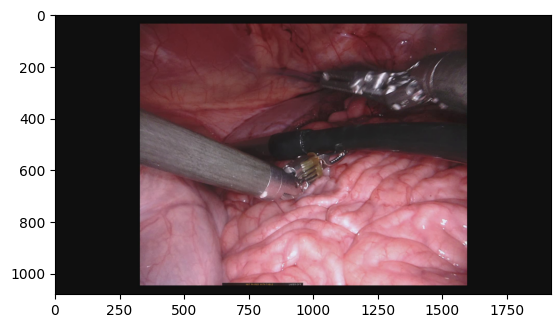

In [149]:
instrument_dataset = "instrument_dataset_01"
frame_num = "frame000.png"
image = io.imread(f"./EndoVis17/train/{instrument_dataset}/left_frames/{frame_num}")
plt.imshow(image)
plt.show()

### After Crop

(1024, 1280, 3)


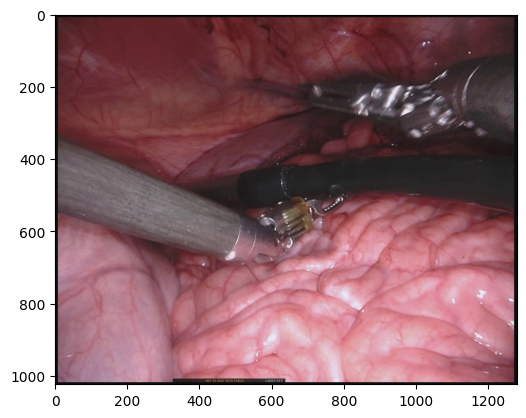

In [150]:
print(image[SLICE_OBJ].shape)
plt.imshow(image[SLICE_OBJ])

### Training Labels

Right_Prograsp_Forceps_labels
[ 0 10 20 30]
0-Background, 10-Shaft, 20-Wrist, 30-Claspers, (1080, 1920)


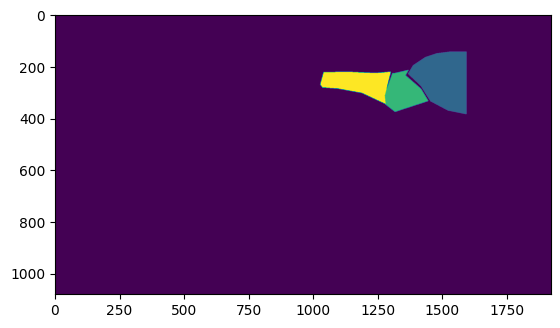

Other_labels
[ 0 40]
0-Background, 40-Probe, (1080, 1920)


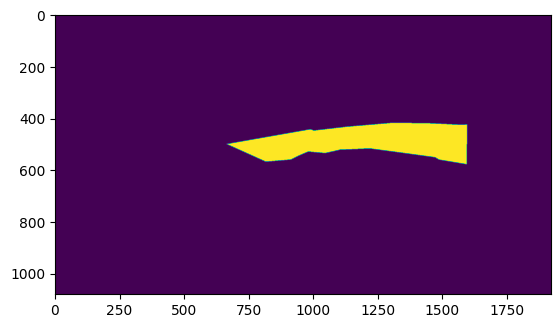

Left_Prograsp_Forceps_labels
[0]
0-Background, (1080, 1920)


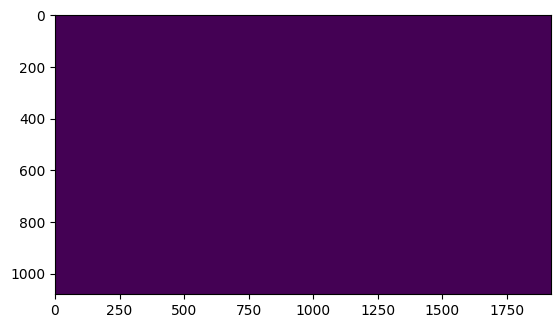

Maryland_Bipolar_Forceps_labels
[ 0 10 20 30]
0-Background, 10-Shaft, 20-Wrist, 30-Claspers, (1080, 1920)


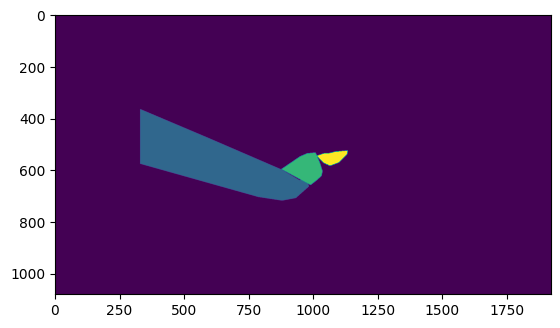

In [151]:
for fol in Path(f"./EndoVis17/train/{instrument_dataset}/ground_truth").iterdir():
    # Ignore folders like .DS_Store, .ipynb_checkpoints
    if "." in fol.name:
        continue
    print(fol.name)
    m = io.imread(fol/frame_num)
    print(np.unique(m))
    for idx in np.unique(m):
        print(f"{idx}-{class2part.get(idx,'INVALID')}", end=", ")
    # for i in np.unique(m):
    #     print(i)
    #     plt.imshow(np.where(m[...,0]==i,1,0))
    #     plt.show()
    print(m.shape)
    plt.imshow(m)
    plt.show()

In [152]:
train_folder = Path("./EndoVis17/train")
test_folder = Path("./EndoVis17/test")

# Creating Masks

Perform the following:
* Crop the Image to remove black borders.
* Each Class for Type Segmentation is a folder, in which each mask is a Part Segmentation of Background, Shaft, Wrist, Jaw and Other with the mapping {
	"Background": 0,
	"Shaft": 10,
	"Wrist": 20,
	"Claspers": 30,
	"Probe": 40
}
* Combine All the Parts for each Instrument and map it to `INS_TYPE` code for Type Segmentaion
* Combine All the Instruments into a Single Mask, with pixel value corresponding to Instrument `class_id` 
* Also Combine all the Instruments into a Single Mask for Part Segmentation.
* And Combine All Parts and Type into a Single Mask for Type and Part Combined Segmentation.

### For Train Folder

Folder Structure

```
> train
    > instrument_dataset_01
        > camera_calibration.txt
        > left_frames
        > right_frames
        > ground_truth
            > Left_Prograsp_Forceps_labels
            > Maryland_Bipolar_Forceps_labels
            > Other_labels
            > Right_Prograsp_Forceps_labels
    > instrument_dataset_02
    ...
    > instrument_dataset_08
```

In [154]:
save_folder = Path("./EndoVis17Processed/train")
os.makedirs(save_folder, exist_ok=True)

sub_folders = ["frames", "binary_masks", "type_masks", "part_masks", "comb_masks"]

In [34]:
for image_type in sub_folders:
    os.makedirs(f"{save_folder}/{image_type}", exist_ok=True)

for folder in train_folder.iterdir():
    if "instrument" not in str(folder.name):
        continue
    print(folder.name)
    # Annotations done are for left_frames, reading them
    frames = sorted((folder/"left_frames").iterdir())
    gt_folder = folder/"ground_truth"

    for image_type in sub_folders:
        os.makedirs(f"{save_folder}/{image_type}/{folder.name}", exist_ok=True)

    # Looping through each frame
    for file in tqdm(frames):
        # If not an Image continue
        if 'png' not in file.suffix:
            continue
        # Reading the Image
        image = io.imread(file)
        # Cropping
        cropped_image = image[SLICE_OBJ]
        # Saving the Cropped Image
        io.imsave(save_folder/"frames"/folder.name/file.name, cropped_image)

        # Creating an Empty Masks (Binary, Part, Type, Combined)
        # sub_folders[1:] -> ["binary_masks", "type_masks", "part_masks", "comb_masks"]
        masks = {m: np.zeros_like(cropped_image[...,0], dtype=np.uint8)
                 for m in sub_folders[1:]}

        # Loop through GT Folders (Different Classes has Different Folders)
        for label_folder in gt_folder.iterdir():
            # Ignore folders like .DS_Store, .ipynb_checkpoints
            if "." in label_folder.name:
                continue

            # Reading the Mask
            label = io.imread(label_folder/file.name)
            
            # Ignore Ultra Probe (Label 40)
            if 40 in np.unique(label):
                continue

            # instrument_dataset_7 has ground_truth 3 channel
            if len(label.shape) > 2:
                label = label[...,0]

            # instrument_dataset_7 has many unknown label_ids
            # e.g np.unique(frame187) -> [ 0 19 20 21 29 30 31]
            # 19,21,29,31 are 1 pixel points, which are mistakes
            if not set(np.unique(label)).issubset({0,10,20,30}):
                for i in np.unique(label):
                    # Replace all those pixels with 0
                    if i not in [0,10,20,30]:
                        label = np.where(label == i, 0, label)

                
            # Cropping
            label = label[SLICE_OBJ]

            # Binary Segmentation
            masks["binary_masks"] = np.where(label != 0, 1, masks["binary_masks"]) 

            # Part Segmentation 
            # Assumption: No overlap between parts of different Instruments
            masks["part_masks"] = np.where(label != 0, label, masks["part_masks"])

            # Getting the `class_id` value from dictionary,
            # Ex: Prograsp Forceps has class_id: 2
            for k,v in INS_CLASSES.items():
                if k in label_folder.name.lower():
                    class_id = v.val

            # The Mask has values 10,20,30 or 40. Any such value change
            # it to class_id, remaining all keep as it is.
            # final_mask here may have class_id from previous iteration.
            masks["type_masks"] = np.where(label != 0, class_id, masks["type_masks"])

            for label_id in np.unique(label):
                # ignore backgroun
                if label_id == 0:
                    continue
                masks["comb_masks"] = np.where(label == label_id, class_id+label_id, masks["comb_masks"])

        # Save the Mask
        for mask_type, mask in masks.items():
            io.imsave(save_folder/mask_type/folder.name/file.name, mask, check_contrast=False)

instrument_dataset_03


100%|██████████| 225/225 [01:24<00:00,  2.67it/s]


instrument_dataset_04


100%|██████████| 225/225 [01:35<00:00,  2.35it/s]


instrument_dataset_05


100%|██████████| 225/225 [01:29<00:00,  2.51it/s]


instrument_dataset_02


100%|██████████| 225/225 [01:12<00:00,  3.12it/s]


instrument_dataset_07


100%|██████████| 225/225 [01:35<00:00,  2.36it/s]


instrument_dataset_08


100%|██████████| 225/225 [01:39<00:00,  2.26it/s]


instrument_dataset_01


100%|██████████| 225/225 [01:38<00:00,  2.29it/s]


instrument_dataset_06


100%|██████████| 225/225 [01:53<00:00,  1.98it/s]


#### Check

frames


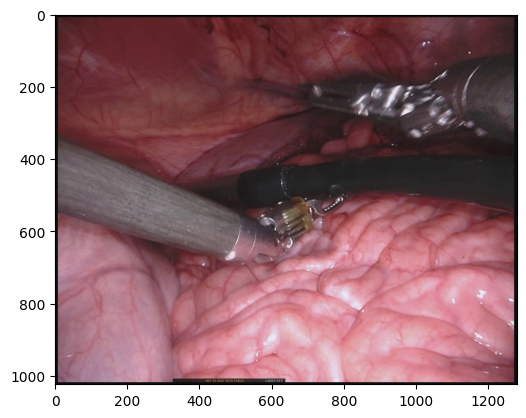

binary_masks
[0 1]


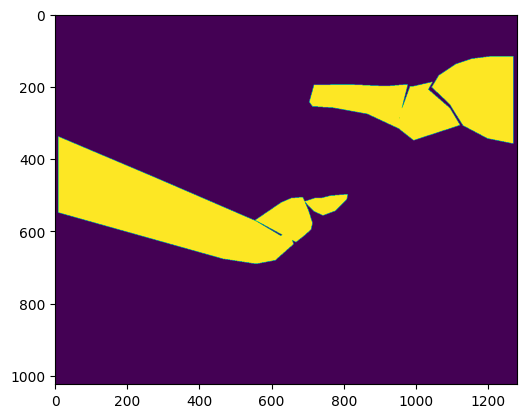

type_masks
[0 1 2]


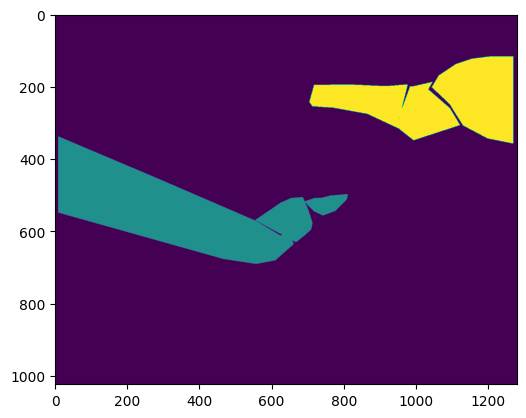

part_masks
[ 0 10 20 30]


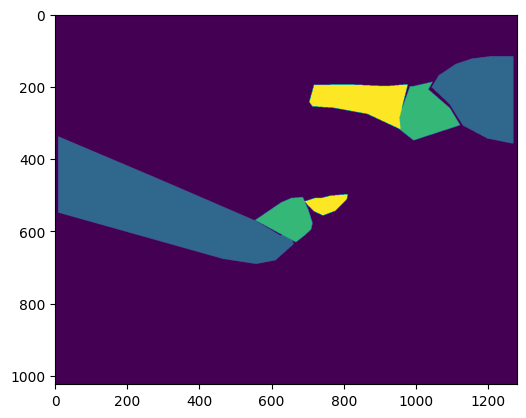

comb_masks
[ 0 11 12 21 22 31 32]


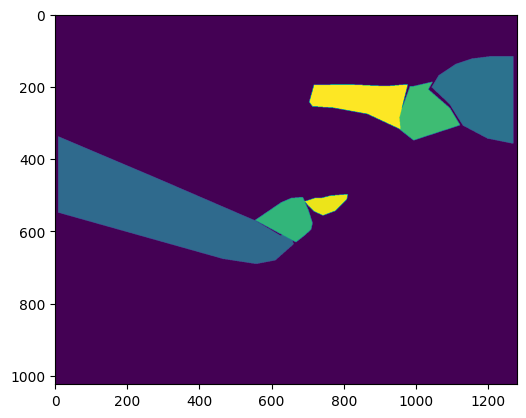

In [157]:
for sub in sub_folders:
    print(sub)
    img = io.imread(save_folder/sub/instrument_dataset/frame_num)
    if len(img.shape) < 3:
        print(np.unique(img))
    plt.imshow(img)
    plt.show()

In [38]:
label_id_dict= {"binary_masks": {0,1},
                 "type_masks": {0,1,2,3,4,5,6},
                 "part_masks": {0,10,20,30},
                 "comb_masks": {i+j for i in range(1,7) for j in range(10,40,10)}.union({0})
                 }

for sub in sub_folders[1:]:
    print(sub)
    for instrument_fol in (save_folder/sub).iterdir():
        # Ignore folders like .DS_Store, .ipynb_checkpoints
        if "." in instrument_fol.name:
            continue
        for file in tqdm(instrument_fol.iterdir()):
            try:
                img = io.imread(file)
            except ValueError as ex:
                print("ERROR", file)
                break
            for i in np.unique(img):
                if i not in label_id_dict[sub]:
                    print(file, np.unique(img), i)
            # break

binary_masks


225it [00:03, 68.85it/s]
225it [00:03, 71.67it/s]
225it [00:03, 71.95it/s]
225it [00:03, 70.24it/s]
225it [00:03, 71.49it/s]
225it [00:03, 73.76it/s]
225it [00:03, 69.44it/s]
225it [00:03, 70.52it/s]


type_masks


225it [00:03, 69.46it/s]
225it [00:03, 73.46it/s]
225it [00:03, 71.59it/s]
225it [00:03, 71.54it/s]
225it [00:03, 74.68it/s]
225it [00:03, 73.09it/s]
225it [00:03, 72.07it/s]
225it [00:03, 71.44it/s]


part_masks


225it [00:03, 68.81it/s]
225it [00:03, 72.82it/s]
225it [00:03, 70.97it/s]
225it [00:03, 70.65it/s]
225it [00:03, 73.87it/s]
225it [00:03, 73.29it/s]
225it [00:03, 71.49it/s]
225it [00:03, 72.20it/s]


comb_masks


225it [00:03, 69.23it/s]
225it [00:03, 73.26it/s]
225it [00:03, 70.87it/s]
225it [00:03, 70.81it/s]
225it [00:03, 73.90it/s]
225it [00:03, 73.37it/s]
225it [00:03, 71.20it/s]
225it [00:03, 71.92it/s]


No issues found!

### For Test folder

Folder Structure
```
> test
    > instrument_dataset_01
        > camera_calibration.txt
        > left_frames
        > right_frames
        > ground_truth
            > BinarySegmentation
            > PartsSegmentation
            > TypeSegmentation
            > TypeSegmentation_Rescaled
    > instrument_dataset_02
    ...
    > instrument_dataset_10
```

#### Visualization for Test Example

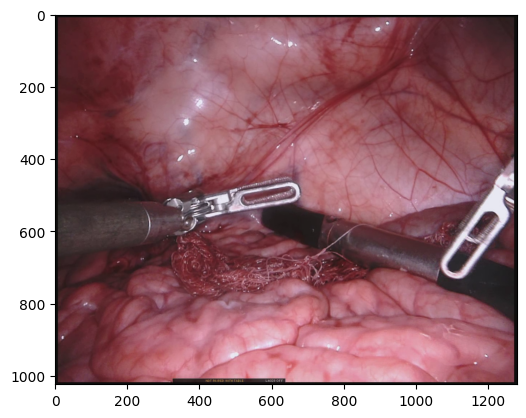

[  0 255] (1080, 1920)


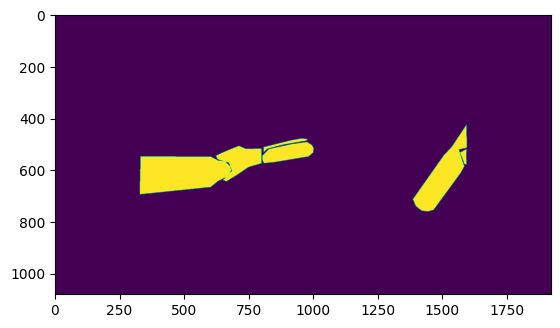

[  0  30 100 255] (1080, 1920)


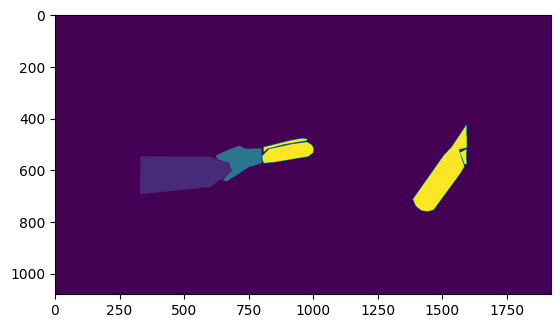

[0 1 2] (1080, 1920)


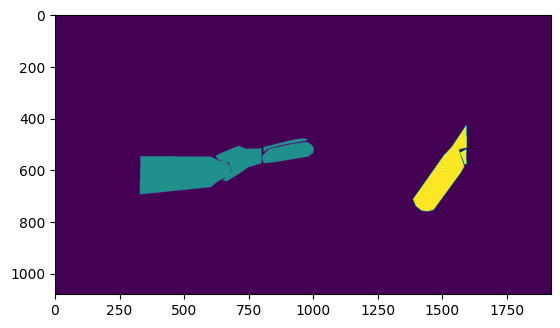

[  0 255] (1080, 1920, 3)


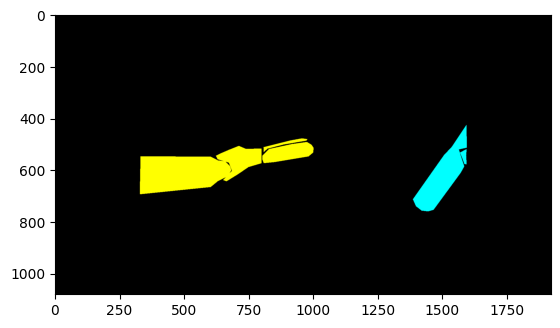

In [ ]:
instrument_dataset = "instrument_dataset_01"
frame_num = "frame225.png"
img = io.imread(f"./EndoVis17/test/{instrument_dataset}/left_frames/{frame_num}")[SLICE_OBJ]
plt.imshow(img);plt.show()
m1 = io.imread(f"./EndoVis17/test/{instrument_dataset}/ground_truth/BinarySegmentation/{frame_num}")
print(np.unique(m1), m1.shape)
plt.imshow(m1);plt.show()

m2 = io.imread(f"./EndoVis17/test/{instrument_dataset}/ground_truth/PartsSegmentation/{frame_num}")
print(np.unique(m2), m2.shape)
plt.imshow(m2);plt.show()

m3 = io.imread(f"./EndoVis17/test/{instrument_dataset}/ground_truth/TypeSegmentation/{frame_num}")
print(np.unique(m3), m3.shape)
plt.imshow(m3);plt.show()

m4 = io.imread(f"./EndoVis17/test/{instrument_dataset}/ground_truth/TypeSegmentationRescaled/{frame_num}")
print(np.unique(m4), m4.shape)
plt.imshow(m4);plt.show()

#### Creating Masks

In [137]:
label_id_dict= {"binary_masks": {0,1},
                 "type_masks": {0,1,2,3,4,5,6},
                 "part_masks": {0,10,20,30},
                 "comb_masks": {i+j for i in range(1,7) for j in range(10,40,10)}.union({0})
                 }

save_folder = Path("./EndoVis17Processed/test")
os.makedirs(save_folder, exist_ok=True)

sub_folders = ["frames", "binary_masks", "type_masks", "part_masks", "comb_masks"]
for image_type in sub_folders:
    os.makedirs(f"{save_folder}/{image_type}", exist_ok=True)

for folder in test_folder.iterdir():
    if "instrument" not in str(folder.name):
        continue
    print(folder.name)
    # Annotations done are for left_frames, reading them
    frames = sorted((folder/"left_frames").iterdir())
    gt_folder = folder/"ground_truth"

    for image_type in sub_folders:
        os.makedirs(f"{save_folder}/{image_type}/{folder.name}", exist_ok=True)

    # Looping through each frame
    for file in tqdm(frames):
        # If not an Image continue
        if '.png' not in file.suffix:
            continue
        # Reading the Image
        image = io.imread(file)
        # Cropping
        cropped_image = image[SLICE_OBJ]
        # Saving the Cropped Image
        # io.imsave(save_folder/"frames"/folder.name/file.name, cropped_image)

        # Creating an Empty Masks (Binary, Part, Type, Combined)
        # sub_folders[1:] -> ["binary_masks", "type_masks", "part_masks", "comb_masks"]
        masks = {m: np.zeros_like(cropped_image[...,0], dtype=np.uint8)
                 for m in sub_folders[1:]}

        # Binary Mask is Present, just Crop
        masks["binary_masks"] = io.imread(gt_folder/"BinarySegmentation"/file.name)[SLICE_OBJ]
        masks["binary_masks"] = np.where(masks["binary_masks"] != 0, 1, 0)

        # Part Segmentation is present but ids are differnt
        # In test, [0,30,100,255] is used [background, shaft, wrist, clasper]
        masks["part_masks"] = io.imread(gt_folder/"PartsSegmentation"/file.name)[SLICE_OBJ]
        test_parts2id = {0:0, 30:10, 100:20, 255:30}
        for i in np.unique(masks["part_masks"]):
            # If area of part mask is less than 0.1% of the image, make pixels 0
            if np.count_nonzero(masks["part_masks"]==i)/masks["part_masks"].size < 0.001:
                masks["part_masks"] = np.where(masks["part_masks"] == i, 0, masks["part_masks"])
                continue

            # If it's not 30/100/255 convert it to zero
            masks["part_masks"] = np.where(masks["part_masks"] == i, test_parts2id.get(i, 0), masks["part_masks"])
            

        masks["type_masks"] = io.imread(gt_folder/"TypeSegmentation"/file.name)[SLICE_OBJ]
        for i in np.unique(masks["type_masks"]):
            # If area of part mask is less than 0.1% of the image, make pixels 0
            if np.count_nonzero(masks["type_masks"]==i)/masks["type_masks"].size < 0.001:
                masks["type_masks"] = np.where(masks["type_masks"] == i, 0, masks["type_masks"])
                continue

            # If pixel value not in {0,1,2,3,4,5,6} convert it to zero
            if i not in label_id_dict["type_masks"]:
                masks["type_masks"] = np.where(masks["type_masks"] == i, 0, masks["type_masks"])

        masks["comb_masks"] = np.where((masks["part_masks"] != 0) & (masks["type_masks"] != 0),
                                       masks["part_masks"] + masks["type_masks"], 0)


        # Save the Mask
        for mask_type, mask in masks.items():
            io.imsave(save_folder/mask_type/folder.name/file.name, mask.astype(np.uint8), check_contrast=False)

instrument_dataset_10


  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [01:21<00:00,  3.68it/s]


instrument_dataset_03


100%|██████████| 75/75 [00:25<00:00,  2.99it/s]


instrument_dataset_04


100%|██████████| 75/75 [00:30<00:00,  2.50it/s]


instrument_dataset_05


100%|██████████| 75/75 [00:19<00:00,  3.84it/s]


instrument_dataset_02


100%|██████████| 75/75 [00:20<00:00,  3.72it/s]


instrument_dataset_07


100%|██████████| 75/75 [00:21<00:00,  3.52it/s]


instrument_dataset_09


100%|██████████| 300/300 [01:25<00:00,  3.53it/s]


instrument_dataset_08


100%|██████████| 75/75 [00:21<00:00,  3.50it/s]


instrument_dataset_01


100%|██████████| 75/75 [00:19<00:00,  3.80it/s]


instrument_dataset_06


100%|██████████| 75/75 [00:26<00:00,  2.78it/s]


#### Check

frames


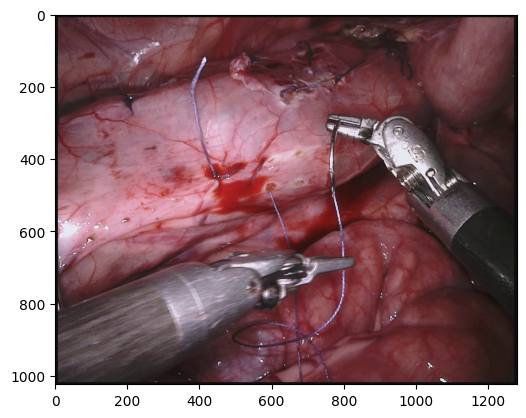

binary_masks
[0 1]


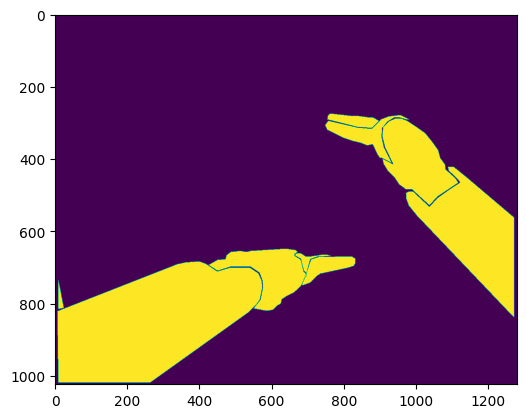

type_masks
[0 3]


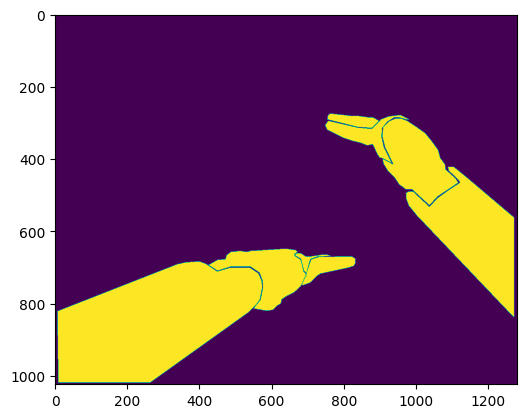

part_masks
[ 0 10 20 30]


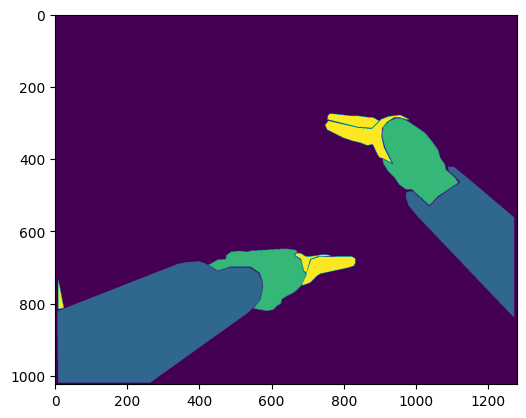

comb_masks
[ 0 13 23 33]


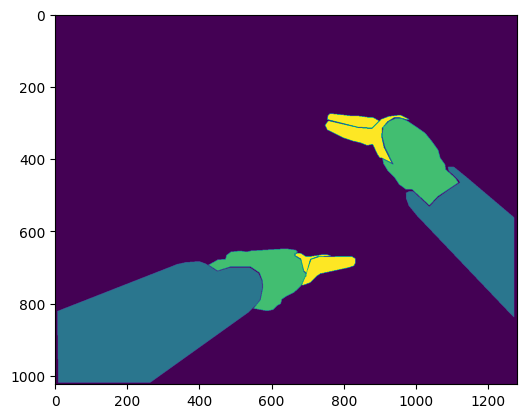

In [ ]:
for sub in sub_folders:
    print(sub)
    img = io.imread(save_folder/sub/instrument_dataset/frame_num)
    if len(img.shape) < 3:
        print(np.unique(img))
    plt.imshow(img)
    plt.show()

#### Example to show that some comb_mask are having area less than 0.01%.

These are not misclassification!

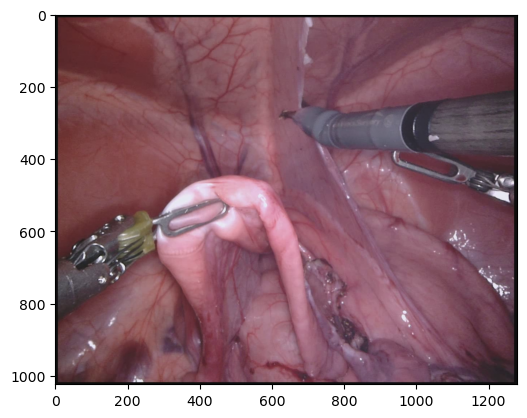

Part Mask label id: 0
Area of Mask covering the image:  88.06465148925781


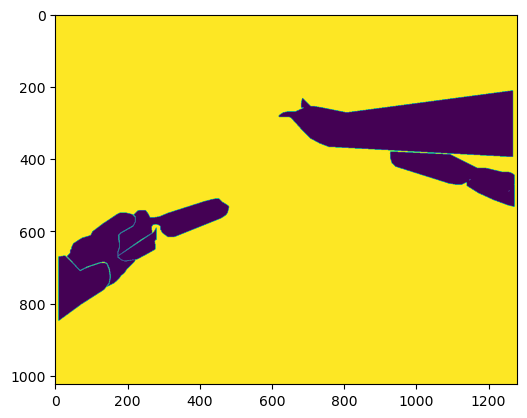

Part Mask label id: 10
Area of Mask covering the image:  7.133026123046875


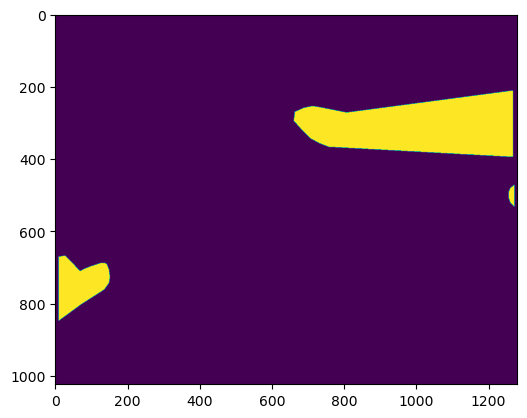

Part Mask label id: 20
Area of Mask covering the image:  1.9893646240234375


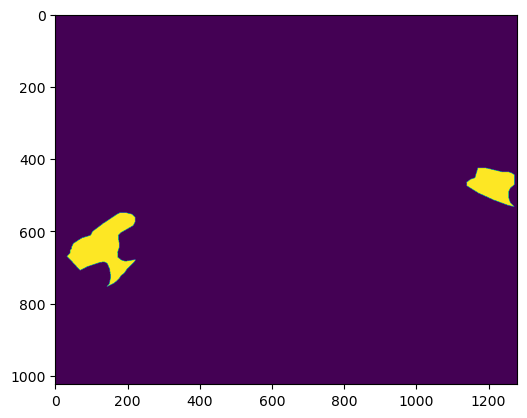

Part Mask label id: 30
Area of Mask covering the image:  2.812957763671875


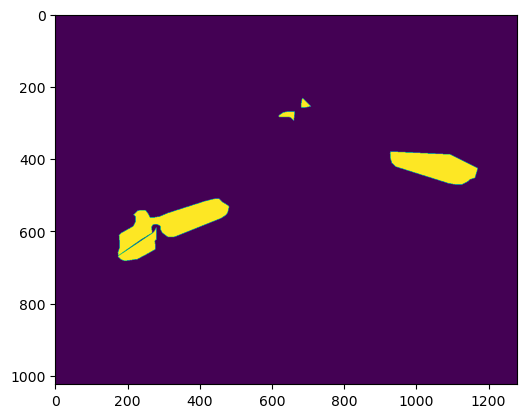

Type Mask label id: 0
Area of Mask covering the image:  88.06465148925781


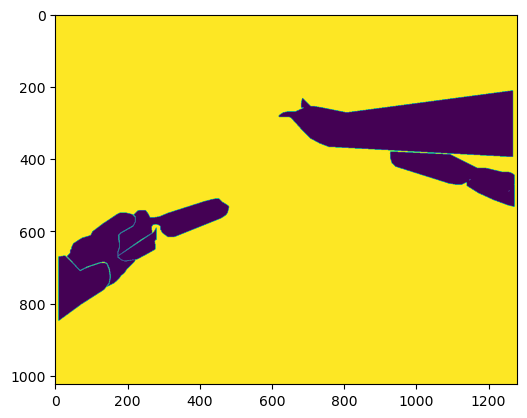

Type Mask label id: 1
Area of Mask covering the image:  4.1478729248046875


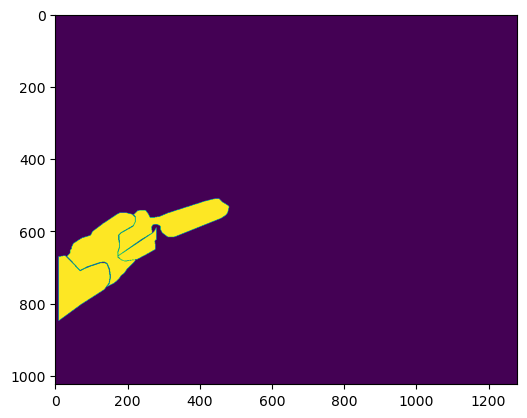

Type Mask label id: 2
Area of Mask covering the image:  1.788787841796875


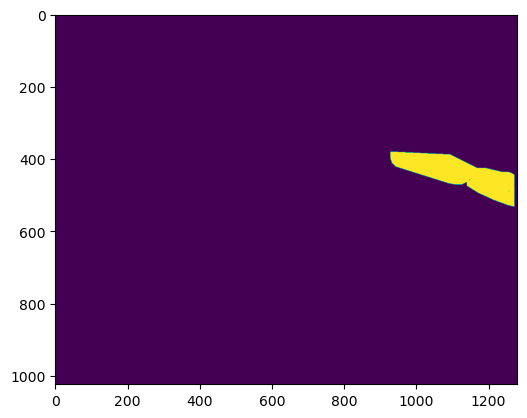

Type Mask label id: 6
Area of Mask covering the image:  5.998687744140625


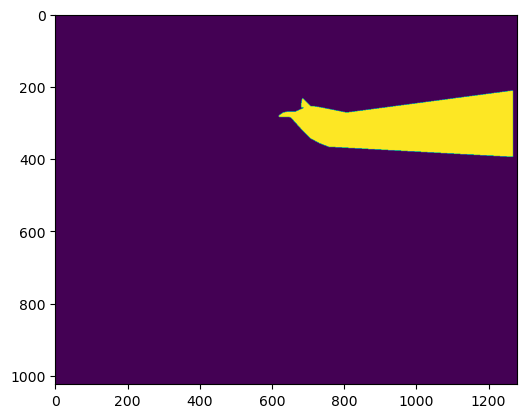

Combined Mask label id: 0
Area of Mask covering the image:  88.06465148925781


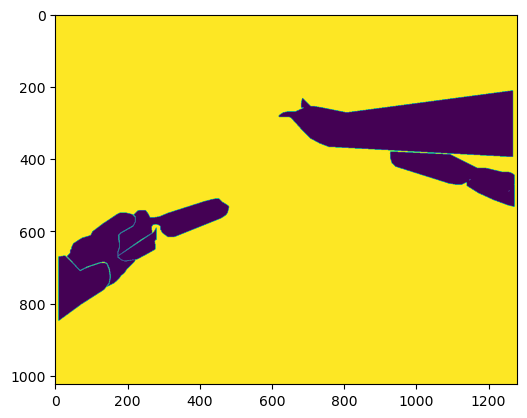

Combined Mask label id: 11
Area of Mask covering the image:  1.157073974609375


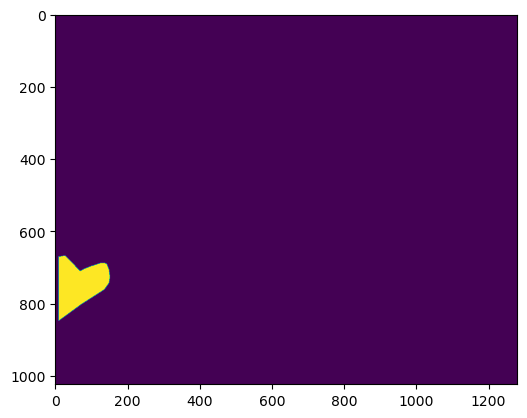

Combined Mask label id: 12
Area of Mask covering the image:  0.05447387695312501


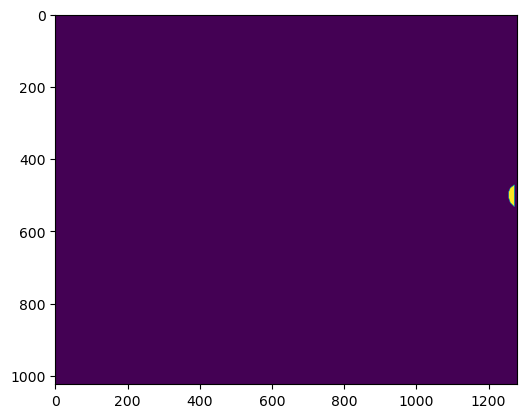

Combined Mask label id: 16
Area of Mask covering the image:  5.921478271484375


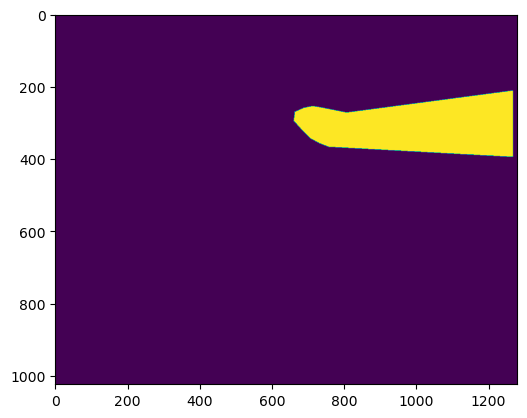

Combined Mask label id: 21
Area of Mask covering the image:  1.3256072998046875


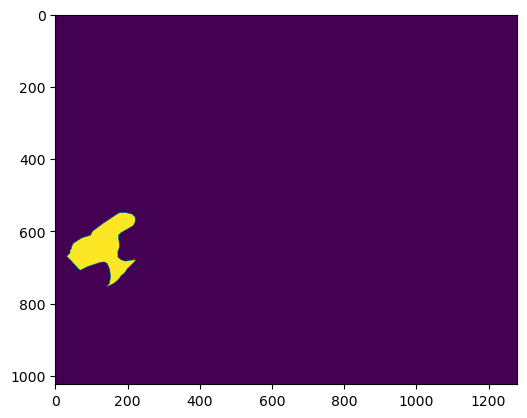

Combined Mask label id: 22
Area of Mask covering the image:  0.66375732421875


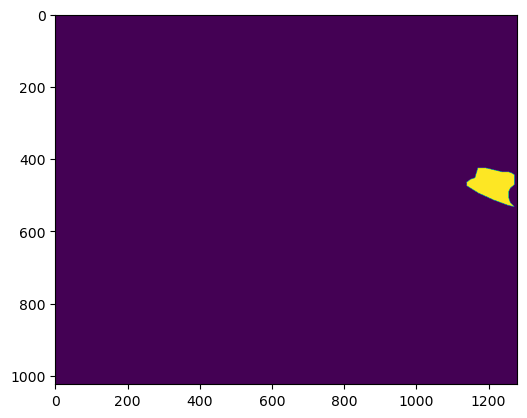

Combined Mask label id: 31
Area of Mask covering the image:  1.665191650390625


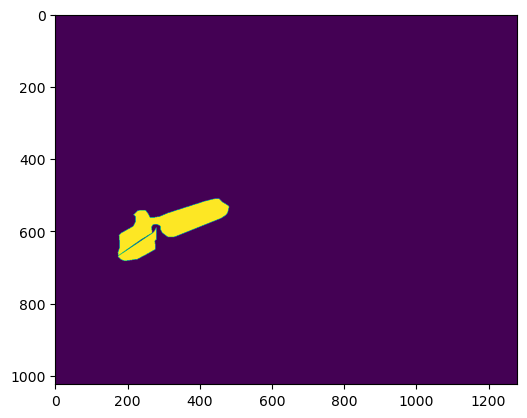

Combined Mask label id: 32
Area of Mask covering the image:  1.070556640625


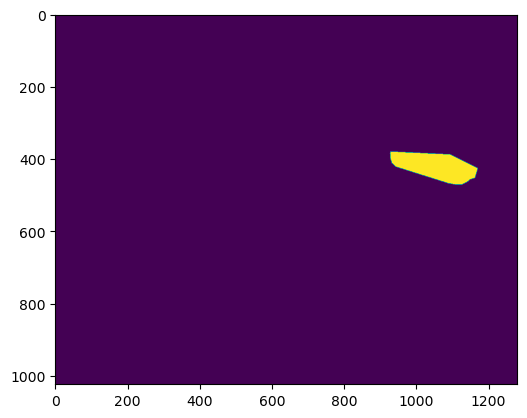

Combined Mask label id: 36
Area of Mask covering the image:  0.07720947265625


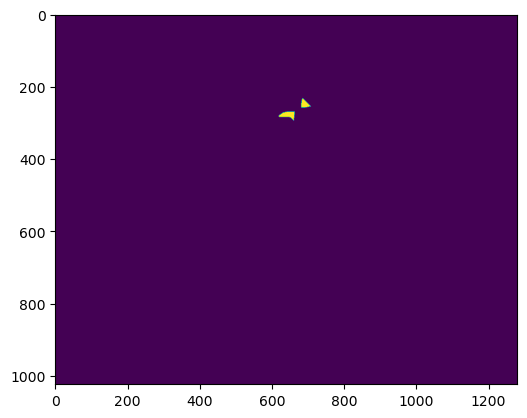

In [8]:
instrument_dataset = "instrument_dataset_09"
frame_num = "frame108.png"
img = io.imread(save_folder/"frames"/instrument_dataset/frame_num)
plt.imshow(img);plt.show()

m2 = io.imread(save_folder/"part_masks"/instrument_dataset/frame_num)
for i in np.unique(m2):
    print("Part Mask label id:", i)
    print("Area of Mask covering the image: ", np.count_nonzero(m2==i)/m2.size * 100)
    plt.imshow(np.where(m2==i,1,0));plt.show()

m3 = io.imread(save_folder/"type_masks"/instrument_dataset/frame_num)
for i in np.unique(m3):
    print("Type Mask label id:", i)
    print("Area of Mask covering the image: ", np.count_nonzero(m3==i)/m3.size * 100)
    plt.imshow(np.where(m3==i,1,0));plt.show()

m4 = io.imread(save_folder/"comb_masks"/instrument_dataset/frame_num)
for i in np.unique(m4):
    print("Combined Mask label id:", i)
    print("Area of Mask covering the image: ", np.count_nonzero(m4==i)/m4.size  * 100)
    plt.imshow(np.where(m4==i,1,0));plt.show()


Checking for Labels which should not be present

In [11]:
label_id_dict= {"binary_masks": {0,1},
                 "type_masks": {0,1,2,3,4,5,6},
                 "part_masks": {0,10,20,30},
                 "comb_masks": {i+j for i in range(1,7) for j in range(10,40,10)}.union({0})
                 }

for sub in sub_folders[1:]:
    print(sub)
    for instrument_fol in (save_folder/sub).iterdir():
        # Ignore folders like .DS_Store, .ipynb_checkpoints
        if "." in instrument_fol.name:
            continue
        for file in tqdm(instrument_fol.iterdir()):
            try:
                img = io.imread(file)
            except ValueError as ex:
                print("ERROR", file)
                break
            for i in np.unique(img):
                # To check if any label id in the mask which should technically not be there
                if i not in label_id_dict[sub]:
                    print(file, np.unique(img), i)
                # TO check if there are any masks with area less than 0.1% of the image
                # elif np.where(img==i,1,0).sum()/(np.where(img==img,1,0)).sum() < 0.001:
                #     print(file, np.unique(img), i)
            # break

binary_masks


0it [00:00, ?it/s]

300it [00:03, 75.23it/s]
75it [00:01, 73.71it/s]
75it [00:00, 77.92it/s]
75it [00:00, 77.27it/s]
75it [00:00, 76.57it/s]
75it [00:00, 78.84it/s]
300it [00:04, 74.97it/s]
75it [00:00, 77.28it/s]
75it [00:01, 74.85it/s]
75it [00:00, 76.83it/s]


type_masks


300it [00:03, 75.94it/s]
75it [00:00, 75.01it/s]
75it [00:00, 77.59it/s]
75it [00:00, 76.39it/s]
75it [00:00, 76.66it/s]
75it [00:00, 80.43it/s]
300it [00:03, 77.67it/s]
75it [00:00, 79.84it/s]
75it [00:00, 76.37it/s]
75it [00:00, 77.19it/s]


part_masks


300it [00:03, 76.63it/s]
75it [00:00, 75.09it/s]
75it [00:00, 77.57it/s]
75it [00:00, 77.25it/s]
75it [00:00, 76.72it/s]
75it [00:00, 79.82it/s]
300it [00:03, 77.82it/s]
75it [00:00, 79.91it/s]
75it [00:00, 75.73it/s]
75it [00:00, 77.99it/s]


comb_masks


300it [00:03, 76.43it/s]
75it [00:01, 74.95it/s]
75it [00:00, 77.88it/s]
75it [00:00, 77.15it/s]
75it [00:00, 77.31it/s]
75it [00:00, 81.24it/s]
300it [00:03, 76.59it/s]
75it [00:00, 76.95it/s]
75it [00:01, 70.67it/s]
75it [00:01, 72.11it/s]


# YOLO Annotations

In [22]:
def contours2poly(contours):
    polygons = []
    for contour in contours:
        epsilon = 0.001 * cv2.arcLength(contour, True)
        contour_approx = cv2.approxPolyDP(contour, epsilon, True)
        polygons.append(contour_approx)

    return polygons

[0 1 2 6]


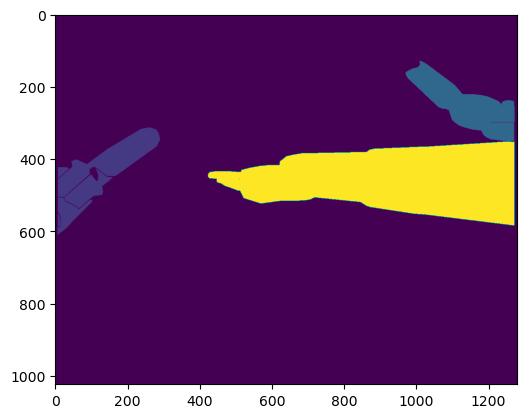

In [6]:
main_folder = Path("../EndoVis17Processed")
sub_folders = ["binary_masks", "type_masks", "part_masks", "comb_masks"]
instrument_dataset = "instrument_dataset_09"
mask = io.imread(main_folder/"test"/sub_folders[1]/instrument_dataset/"frame000.png")
print(np.unique(mask))
plt.imshow(mask)

In [37]:
for train_val in main_folder.iterdir():
    if "." in train_val.name:
        continue
    # Using Type Masks, to get Polygon of each Instrument Type Separately.
    for instrument_dataset in (train_val/"type_masks").iterdir():
        # Ignore folders like .DS_Store, .ipynb_checkpoints
        if "." in instrument_dataset.name:
            continue
        # Create Instrument Dataset folder
        os.makedirs(f"../yolo_labels/{train_val.name}/{instrument_dataset.name}", exist_ok=True)

        for multiclass_mask in tqdm(sorted(instrument_dataset.iterdir())):
            if 'png' not in multiclass_mask.name:
                continue
            # Load the binary mask image
            initial_mask = cv2.imread(str(multiclass_mask), cv2.IMREAD_GRAYSCALE)

            # Ignore if the mask is empty
            if np.sum(initial_mask) == 0:
                continue

            for cls_idx in np.unique(initial_mask):
                if cls_idx == 0:
                    continue
                # Get Binary Mask of each Instrument Type
                mask = np.where(initial_mask == cls_idx, 255, 0).astype(np.uint8)
                # Define a small kernel for dilation and erosion
                kernel = np.ones((7, 7), np.uint8)
                # Apply Dilation and Erosion
                mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

                # Find contours in the binary mask
                contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_KCOS)

                polygons = contours2poly(contours)

                wh = np.flip(np.array(mask.shape)) # for normalization purposes
                norm_polygons = [polygon / wh for polygon in polygons]
                xy_sequences = [polygon.flatten().tolist() for polygon in norm_polygons]

                # Write this information to your YOLO format text file
                txt_path = f"../yolo_labels/{train_val.name}/{instrument_dataset.name}/{multiclass_mask.stem}.txt"
                with open(txt_path, 'a') as f:
                    for xy_sequence in xy_sequences:
                        xy_sequence = " ".join(map(str, xy_sequence))
                        # YOLO Class Index starts from 0
                        f.write(f'{cls_idx-1} {xy_sequence}\n')

100%|██████████| 225/225 [00:04<00:00, 51.32it/s]


In [8]:
def overlay_poly_on_image(polygons, image):
    # Iterate through YOLO polygons and overlay them on the image
    for polygon in polygons:
        class_id = polygon[0]
        points = polygon[1:]

        # Convert YOLO coordinates to pixel coordinates
        x_coords_px = [int(coord * image.shape[1]) for i, coord in enumerate(points) if i % 2 == 0]
        y_coords_px = [int(coord * image.shape[0]) for i, coord in enumerate(points) if i % 2 != 0]

        # Reshape coordinates as a list of points
        pts = np.array(list(zip(x_coords_px, y_coords_px)), np.int32)
        pts = pts.reshape((-1, 1, 2))

        # Draw the polygon on the image
        color = (0, 255, 0)  # Green color for the polygon outline
        thickness = 2
        image = cv2.polylines(image, [pts], isClosed=True, color=color, thickness=thickness)

        # Add class label if needed
        label = f'Class {int(class_id)}'
        label_x = min(1280-80, x_coords_px[0])
        label_y = y_coords_px[0] - 10
        cv2.putText(image, label, (label_x, label_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, thickness)

    # Convert BGR image to RGB format for Matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image_rgb

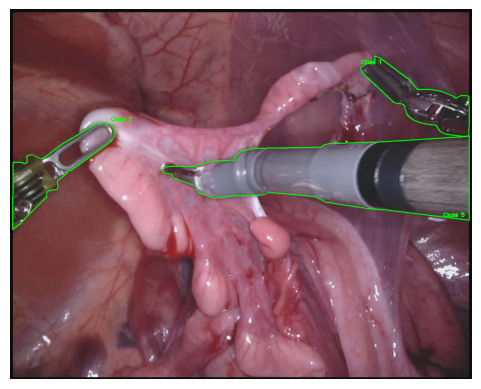

In [9]:
instrument_dataset = "instrument_dataset_09"
frame_num = "frame000"

# Load your image
image = cv2.imread(str(main_folder/"test/frames"/instrument_dataset/frame_num)+".png")

with open(f"../yolo_labels/test/{instrument_dataset}/{frame_num}.txt", 'r') as f:
    data = f.readlines()
    
data = [i.strip().split() for i in data]
yolo_polygons = [ [int(i[0]),  *[float(j) for j in i[1:]] ] for i in data]
image = overlay_poly_on_image(yolo_polygons, image)

# Display the image with overlay
plt.imshow(image)
plt.axis('off')  # Turn off axis labels and ticks
plt.show()


In [15]:
frames_dict = {}

for image_path in sorted((main_folder/"test/frames"/instrument_dataset).iterdir()):
    if 'png' not in image_path.suffix:
          continue
    image = cv2.imread(str(image_path))
    
    with open(f"../yolo_labels/test/{instrument_dataset}/{image_path.stem}.txt", 'r') as f:
        data = f.readlines()
    data = [i.strip().split() for i in data]
    yolo_polygons = [ [int(i[0]),  *[float(j) for j in i[1:]] ] for i in data]

    image = overlay_poly_on_image(yolo_polygons, image)

    frames_dict[image_path.stem] = image

frame = frames_dict[list(frames_dict.keys())[-1]]
size1,size2,_ = frame.shape
out = cv2.VideoWriter(f"../{instrument_dataset}.mp4", cv2.VideoWriter_fourcc(*'mp4v'), 1, (size2, size1), True)
# Sorting the frames according to frame number eg: frame_007.png
for _,i in sorted(frames_dict.items(), key=lambda x: x[0]):
    out_img = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
    out.write(out_img)
out.release()